### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Modeling (this notebook)
- [Experiments](./03a_experiments.ipynb)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- Classification models for each of the 3 datasets
- Hyperparameter tuning via GridSearchCV
- Brief analyses of each model

In [109]:
# The usual imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, precision_score

# to persist our models for later use
import pickle

# global random seed
np.random.seed(42)

##### Universal model evaluation function
- We will use the below Dataframe and functions to accumulate metrics on all of our models across all of our datasets to facilitate
evaluation and production model selection.
- We've chosen to make 2 different versions of our **model_trials** function - the first is for non-neural-network models, and the second
is for neural networks - to accommodate the differences in parameters, fitting, and scoring between the 2 types of models.
- Thanks to Cynthia Rodriguez for this one!

In [110]:
# Dataframe to collect results
model_trials_df = pd.DataFrame(columns=['dataset_name', 'model_used', 'model_params', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

def model_trials(dataset_name, X, y, model, model_id, scale_first = False, gs_params = None):
    '''
    Takes in dataset information and a (non-neural-net) model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): non-neural-net model to fit
    - model_id (string): friendly name for model to include in results
    - scale_first (boolean): indicates whether the feature set X should be scaled before fitting
    - gs_params (dict): parameters for a GridSearch - if None, model will be fit without GridSearching

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    '''Scale if needed'''
    if (scale_first):
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    if (gs_params):
        gs = GridSearchCV(model, gs_params, n_jobs = -1)
        gs.fit(X_train, y_train)
        model = gs.best_estimator_
        model_params = gs.best_params_
    else:
        model.fit(X_train, y_train)
        model_params = model.get_params()

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

In [111]:
# neural net version
def model_trials_nn(dataset_name, X, y, model, model_id, epochs = 10, batch_size = 32, callbacks = None):
    '''
    Takes in dataset information and a neural network model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion. NOTE: assumes model's
    output layer uses the sigmoid activation function (i.e., binary classification) and was compiled with 'accuracy' among its metrics.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): neural network model to fit
    - model_id (string): friendly name for model to include in results
    - epochs (int): number of neural network epochs to run
    - batch_size (int): size of neural network batch
    - callbacks (list): list of callbacks to invoke while fitting, e.g., EarlyStopping

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    '''Always scale for neural nets!'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    res = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size, callbacks = callbacks, verbose = 0)
    model_params = {'epochs': epochs, 'batch_size': batch_size} # all we'll capture for these - there are too many weights to be useful!
        
    train_score = res.history['accuracy'][-1]
    test_score = res.history['val_accuracy'][-1]

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    '''Assumes a 0.5 probability threshold'''
    preds = [1 if x >= 0.5 else 0 for x in model.predict(X_test)[:, 0]]
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'viridis', values_format = 'd');
    else: 
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', values_format = 'd');

---
**Model 1: Base feature set - New York**

In [106]:
# read in the clean NY data and remind ourselves what it looks like
ny_df = pd.read_csv('../data/NY/NY_final.csv')
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


##### Basic Models- Two Features Gender and Age

In [107]:
# Define X and y
X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

Dataset: NY
Model ID: logreg gen/age
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.5868
Testing Score: 0.5879 

Accuracy: 0.5879
Specificity: 0.9707
Precision: 0.5615
Recall: 0.0525
F1 Score: 0.096 

Best accuracy rate confusion matrix:


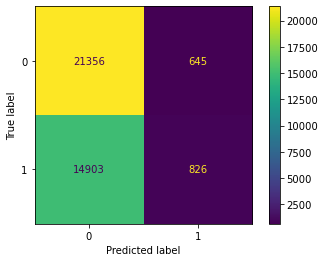

In [108]:
# Vanilla Logistic Regression
ny_logreg = LogisticRegression()
model_trials('NY', X, y, ny_logreg, 'logreg gen/age');

ANALYSIS
- Initial logistic regression scores are low-variance, but high-bias - essentially no better than our baseline accuracy of 58%.
- Specificity is good, indicating low propensity for false negatives.

Dataset: NY
Model ID: rf gen/age
Model Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.918
Precision: 0.5196
Recall: 0.124
F1 Score: 0.2002 

Best accuracy rate confusion matrix:


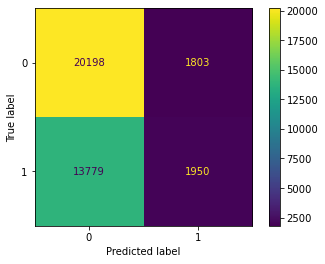

In [13]:
# Random Forest
ny_rf = RandomForestClassifier()
model_trials('NY', X, y, ny_rf, 'rf gen/age');

ANALYSIS
- Similar to Logistic Regression - low variance, high bias, no real improvement over baseline.
- Specificity is still fairly high, though not as high as Logistic Regression.

Dataset: NY
Model ID: ada gen/age
Model Params: {'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.918
Precision: 0.5196
Recall: 0.124
F1 Score: 0.2002 

Best accuracy rate confusion matrix:


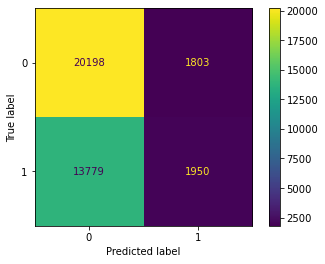

In [14]:
# AdaBoost
ny_ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
model_trials('NY', X, y, ny_ada, 'ada gen/age');

ANALYSIS
- Very similar to Random Forest
- Still no real improvement in accuracy
- Specificity is similar as well

Dataset: NY
Model ID: grad gen/age
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.9182
Precision: 0.5195
Recall: 0.1237
F1 Score: 0.1998 

Best accuracy rate confusion matrix:


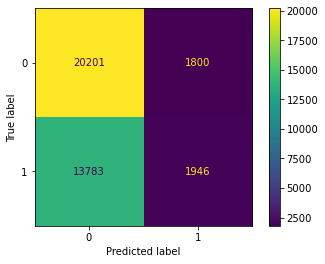

In [15]:
# GradientBoost
ny_gboost = GradientBoostingClassifier()
model_trials('NY', X, y, ny_gboost, 'grad gen/age');

ANALYSIS
- More in the same vein - low variance, high bias, no real improvement over baseline
- Specificity remains fairly high

Dataset: NY
Model ID: stack gen/age
Model Params: {'cv': None, 'estimators': [('random_forest', RandomForestClassifier()), ('gboost', GradientBoostingClassifier()), ('ada', AdaBoostClassifier())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'random_forest': RandomForestClassifier(), 'gboost': GradientBoostingClassifier(), 'ada': AdaBoostClassifier(), 'random_forest__bootstrap': True, 'random_f

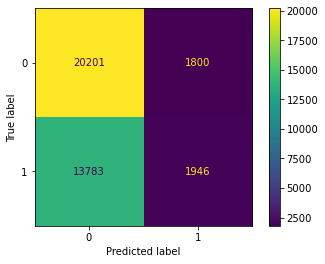

In [16]:
# Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

ny_stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

model_trials('NY', X, y, ny_stacked_model, 'stack gen/age');

ANALYSIS
- Still no improvement over baseline
- Very similar to previous models

Dataset: NY
Model ID: knn gen/age
Model Params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training Score: 0.5319
Testing Score: 0.5313 

Accuracy: 0.5313
Specificity: 0.6467
Precision: 0.428
Recall: 0.3698
F1 Score: 0.3968 

Best accuracy rate confusion matrix:


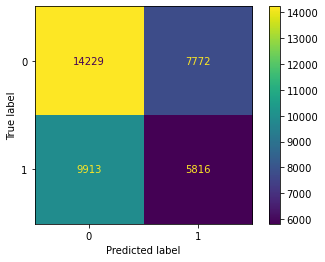

In [17]:
# KNN
ny_knn = KNeighborsClassifier()

model_trials('NY', X, y, ny_knn, 'knn gen/age', scale_first = True);

ANALYSIS
- Training and testing accuracy are noticeably worse than previous models
- Specificity has dropped drastically, by almost 0.30

##### Models Including County, Gender, Age

In [18]:
# Creating a Dataframe including dummies of the county of indictment
df_dummies = pd.get_dummies(ny_df['County of Indictment'])
df_dummies['gender'] = ny_df['gender_map']
df_dummies['recidivism'] = ny_df['recidivism']
df_dummies['age'] = ny_df['Age at Release']

# Define X and y with dummy data
X = df_dummies.drop(columns = ['recidivism'])
y = df_dummies['recidivism']

Dataset: NY
Model ID: logreg gen/age/cty
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.5987
Testing Score: 0.599 

Accuracy: 0.599
Specificity: 0.8768
Precision: 0.5498
Recall: 0.2105
F1 Score: 0.3044 

Best accuracy rate confusion matrix:


c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


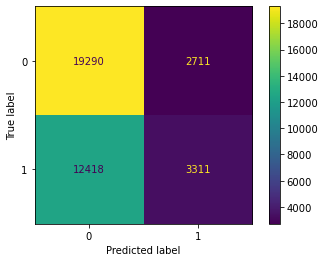

In [19]:
# Logistic Regression
ny_lr2 = LogisticRegression()
model_trials('NY', X, y, ny_lr2, 'logreg gen/age/cty');

ANALYSIS
- We're finally seeing some improvement in our model with the addition of the county of indictment - about 0.01 uptick in accuracy
- We have, however, lost some specificity compared to previous models - about 0.04 decrease

Dataset: NY
Model ID: rf gen/age/cty
Model Params: {'max_depth': 15, 'max_features': 15, 'n_estimators': 120}
Training Score: 0.6028
Testing Score: 0.5971 

Accuracy: 0.5971
Specificity: 0.8957
Precision: 0.5517
Recall: 0.1795
F1 Score: 0.2709 

Best accuracy rate confusion matrix:


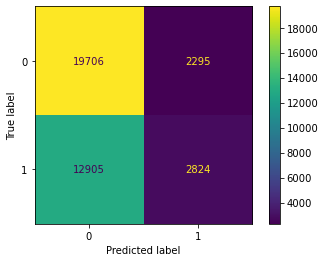

In [20]:
# Random Forest with Hyperparameter tuning
ny_rf2 = RandomForestClassifier()
rf_params = {
    'n_estimators': [120, 130],
    'max_depth': [15, 20],
    'max_features' : [15, 20]
}

model_trials('NY', X, y, ny_rf2, 'rf gen/age/cty', gs_params = rf_params);

ANALYSIS
- Another slight improvement over the Logistic Regression using this dataset, finally broke 0.60 accuracy
- Specificity remains reasonably high

Dataset: NY
Model ID: ada gen/age/cty
Model Params: {'base_estimator__max_depth': 1, 'n_estimators': 100}
Training Score: 0.5996
Testing Score: 0.6 

Accuracy: 0.6
Specificity: 0.8708
Precision: 0.5504
Recall: 0.2213
F1 Score: 0.3157 

Best accuracy rate confusion matrix:


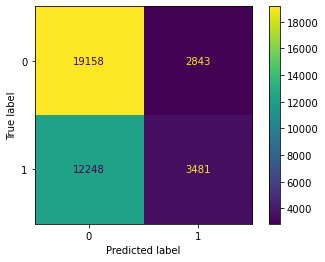

In [21]:
#Ada Boost with Hyperparameter tuning
ny_ada2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

ada_params= {
    'n_estimators': [50, 100],
    'base_estimator__max_depth':[1, 3]
}

model_trials('NY', X, y, ny_ada2, 'ada gen/age/cty', gs_params = ada_params);

ANALYSIS
- Arguably our best model so far, with train and test accuracy of 0.60
- Specificity is still reasonably high at 0.87

Dataset: NY
Model ID: grad gen/age/cty
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.5989
Testing Score: 0.5988 

Accuracy: 0.5988
Specificity: 0.9183
Precision: 0.5708
Recall: 0.152
F1 Score: 0.2401 

Best accuracy rate confusion matrix:


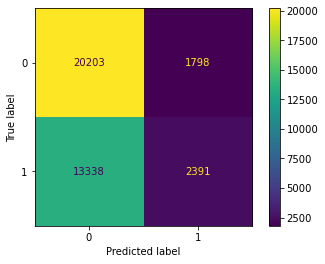

In [22]:
# Gradient Boost
ny_gboost2 = GradientBoostingClassifier()
model_trials('NY', X, y, ny_gboost2, 'grad gen/age/cty');

ANALYSIS
- Accuracy is essentially the same as AdaBoost
- Noticeable increase in specificity of about 0.04

Dataset: NY
Model ID: stack gen/age/cty
Model Params: {'cv': None, 'estimators': [('random_forest', RandomForestClassifier()), ('gboost', GradientBoostingClassifier())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'random_forest': RandomForestClassifier(), 'gboost': GradientBoostingClassifier(), 'random_forest__bootstrap': True, 'random_forest__ccp_alpha': 0.0, 'random_forest__class_weight': N

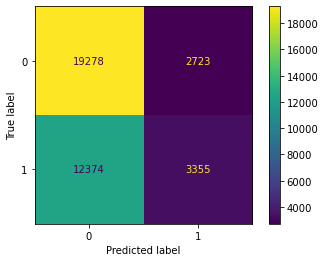

In [23]:
# Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier())
]

ny_stacked_model2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

model_trials('NY', X, y, ny_stacked_model2, 'stack gen/age/cty');

ANALYSIS
- Train and test accuracy essentially the same as GradientBoost, which is one of the stack components
- Some loss of specificity - about 0.04 - possibly due to introduction of Random Forest influence

In [24]:
# Since we're about to create a neural network - remind ourselves of the number of inputs
X.shape

(188650, 65)

1180/1180 [==============================] - 1s 1ms/step
Dataset: NY
Model ID: fnn gen/age/cty
Model Params: {'epochs': 10, 'batch_size': 32}
Training Score: 0.5998
Testing Score: 0.6005 

Accuracy: 0.6005
Specificity: 0.8841
Precision: 0.5568
Recall: 0.2037
F1 Score: 0.2983 

Best accuracy rate confusion matrix:


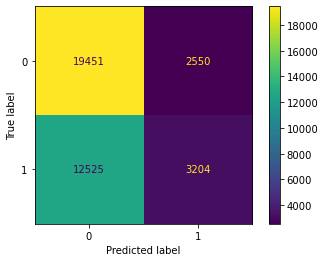

In [25]:
# Instantiate a CNN.
ny_nn = Sequential()

ny_nn.add(Dense(84, input_shape = (65,), activation = 'relu'))
ny_nn.add(Dense(64, activation = 'relu'))
ny_nn.add(Dense(32, activation = 'relu'))
ny_nn.add(Dense(1, activation = 'sigmoid'))

# Compile it
ny_nn.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# Fit it
model_trials_nn('NY', X, y, ny_nn, 'fnn gen/age/cty');

ANALYSIS
- Very similar statistics to our best so far, GradientBoost, but has a slight edge in test accuracy
- Slight drop in specificity - less than 0.03 - not significant enough to dissuade us from using this model
- This will probably be our production model for the NY dataset, but we will perform some additional inspection in the final notebook to ensure that this is the best choice

---
**Model 2: Criminal history feature set - Florida**

In [27]:
# read in clean dataset
fl = pd.read_csv('../data/FL/FL_final.csv')
fl.columns

Index(['person_id', 'num_incarcerations', 'comp_f_min_score',
       'comp_f_min_decile', 'comp_f_max_score', 'comp_f_max_decile',
       'comp_r_min_score', 'comp_r_min_decile', 'comp_r_max_score',
       'comp_r_max_decile', 'comp_v_min_score', 'comp_v_min_decile',
       'comp_v_max_score', 'comp_v_max_decile', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'charge_degree_count_F1', 'charge_degree_count_F2',
       'charge_degree_count_F3', 'charge_degree_count_F5',
       'charge_degree_count_F6', 'charge_degree_count_F7',
       'charge_degree_count_M1', 'charge_degree_count_M2',
       'charge_degree_count_M3', 'agg_charges', 'avg_days_between_offenses',
       'avg_days_between_arrests', 'first_charge_degree_F1',
       'first_charge_degree_F2', 'first_charge_degree_F3',
       'first_charge_degree_F5', 'first_charge_degree_F6',
       'first_charge_degree_F7', 'first_charge_degree_M1',
       'first_charge_degree

- We should drop all columns that were used only for EDA and will not be considered for the model.
- We should also check the distribution of our target class to determine whether any rebalancing is needed.

In [28]:
# drop all non-model columns
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'agg_charges', # will be used for NLP experiment
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

In [29]:
# check the target class distribution (also our baseline accuracy)
fl['recidivism'].value_counts(normalize = True)

0    0.607327
1    0.392673
Name: recidivism, dtype: float64

- Our dataframe now contains only potential features and the target columns.
- Our classes are slightly imbalanced, but not significantly more than the other datasets and not enough to merit rebalancing.
- We will move on to GridSearching various models, evaluating each and storing statistics as we go.

In [31]:
# set up X and y
X = fl.drop(columns = ['recidivism'])
y = fl['recidivism']

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 55, in _check_solver
    raise ValueError(
ValueE

Dataset: FL
Model ID: logreg
Model Params: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Training Score: 0.8286
Testing Score: 0.8365 

Accuracy: 0.8365
Specificity: 0.9087
Precision: 0.837
Recall: 0.7249
F1 Score: 0.7769 

Best accuracy rate confusion matrix:


c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


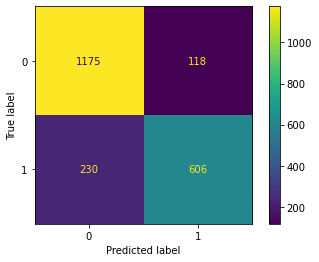

In [32]:
# LogisticRegression
# NOTE that we expect some warnings due to incompatible permutations of parameters
fl_logreg = LogisticRegression()
params = {
    'penalty': ['None', 'l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.1, 0.5, 1.0]
}

model_trials('FL', X, y, fl_logreg, 'logreg', gs_params = params);

ANALYSIS
- Surprisingly high accuracy with vanilla logistic regression - already above our target of 80%
- Test accuracy is actually higher than training
- Specificity is very solid at 0.9

Dataset: FL
Model ID: knn
Model Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Training Score: 0.9994
Testing Score: 0.822 

Accuracy: 0.822
Specificity: 0.8871
Precision: 0.8051
Recall: 0.7213
F1 Score: 0.7609 

Best accuracy rate confusion matrix:


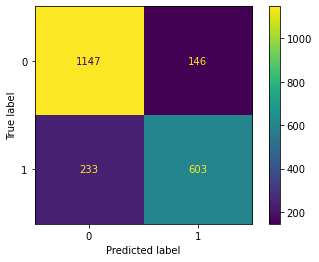

In [33]:
# KNN
fl_knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 8],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

model_trials('FL', X, y, fl_knn, 'knn', gs_params = params);

- Very impressive training score - almost perfect!
- Unfortunately, as we might expect with KNN at higher dimensionality, we're pretty severely overfit
- Specificity is still a solid 0.89

Dataset: FL
Model ID: bag
Model Params: {'n_estimators': 20}
Training Score: 0.9965
Testing Score: 0.8638 

Accuracy: 0.8638
Specificity: 0.8786
Precision: 0.8174
Recall: 0.8409
F1 Score: 0.829 

Best accuracy rate confusion matrix:


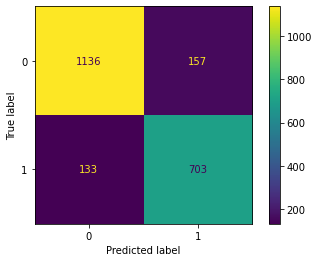

In [34]:
# Bagging
fl_bag = BaggingClassifier()
params = {
    'n_estimators': [10, 20]
}

model_trials('FL', X, y, fl_bag, 'bag', gs_params = params);

ANALYSIS
- Very similar performance to KNN, actually, though slightly less overfit
- Specificity remains acceptable

Dataset: FL
Model ID: rf
Model Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Training Score: 0.8916
Testing Score: 0.8779 

Accuracy: 0.8779
Specificity: 0.8608
Precision: 0.8077
Recall: 0.9043
F1 Score: 0.8533 

Best accuracy rate confusion matrix:


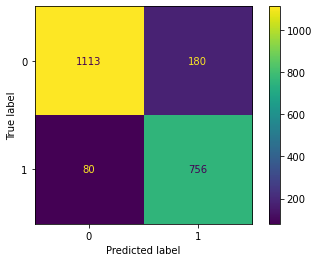

In [35]:
# Random Forest
fl_rf = RandomForestClassifier()
params = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

model_trials('FL', X, y, fl_rf, 'rf', gs_params = params);

ANALYSIS
- Our best model so far! Shockingly low bias, very low variance as well
- Specificity is still acceptable, although we are seeing a slight (0.01-0.02) drop

Dataset: FL
Model ID: ada
Model Params: {'learning_rate': 1, 'n_estimators': 100}
Training Score: 0.8638
Testing Score: 0.8661 

Accuracy: 0.8661
Specificity: 0.8592
Precision: 0.8011
Recall: 0.8768
F1 Score: 0.8372 

Best accuracy rate confusion matrix:


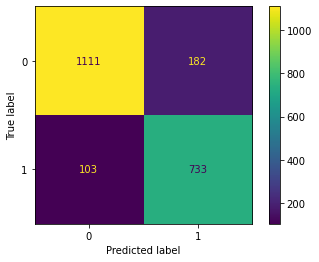

In [36]:
# AdaBoost
fl_ada = AdaBoostClassifier()
params = {
    'n_estimators': [50, 100],
    'learning_rate': [1, 5, 10]
}

model_trials('FL', X, y, fl_ada, 'ada', gs_params = params);

ANALYSIS
- Very low variance, but bias is a bit lackluster compared to Random Forest
- Specificity is also lower than previous models

Dataset: FL
Model ID: grad
Model Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 1.0}
Training Score: 0.8866
Testing Score: 0.8816 

Accuracy: 0.8816
Specificity: 0.8716
Precision: 0.8188
Recall: 0.8971
F1 Score: 0.8562 

Best accuracy rate confusion matrix:


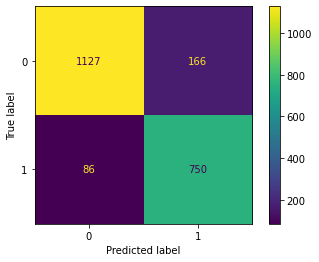

In [37]:
# GradientBoost
fl_grad = GradientBoostingClassifier()
params = {
    'n_estimators': [100, 150],
    'subsample': [0.7, 1.0],
    'learning_rate': [0.1, 1, 10],
    'max_depth': [3, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

model_trials('FL', X, y, fl_grad, 'grad', gs_params = params);

ANALYSIS
- This model now looks to be in the lead - it has a tiny bit more bias than the Random Forest, but essentially no variance
- Specificity is also a bit higher - about 0.87 - definitely within acceptable limits

In [38]:
# checking input shape for neural networks
X.shape

(10645, 34)

67/67 [==============================] - 0s 978us/step
Dataset: FL
Model ID: fnn1
Model Params: {'epochs': 20, 'batch_size': 256}
Training Score: 0.8525
Testing Score: 0.8544 

Accuracy: 0.8544
Specificity: 0.8616
Precision: 0.7975
Recall: 0.8433
F1 Score: 0.8198 

Best accuracy rate confusion matrix:


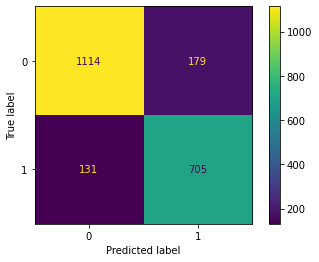

In [40]:
# FNN w/layer of 32 and layer of 16 neurons
fl_fnn1 = Sequential()
fl_fnn1.add(Dense(units = 32, activation = 'relu', input_shape = (34, )))
fl_fnn1.add(Dense(units = 16, activation = 'relu'))
fl_fnn1.add(Dense(units = 1, activation = 'sigmoid'))

fl_fnn1.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

model_trials_nn('FL', X, y, fl_fnn1, 'fnn1', epochs = 20, batch_size = 256);

ANALYSIS
- Very solid performance, essentially no variance, accuracy of around 0.85 on both train and test
- Specificity is a bit on the low side compared to most of our other models
- Doesn't quite come up to the bar set by the GradientBoost
- We will try a few regularization techniques out of curiosity, but given the extremely low variance of this initial neural network, we probably won't be able to improve on these scores

67/67 [==============================] - 0s 1ms/step
Dataset: FL
Model ID: fnn2
Model Params: {'epochs': 20, 'batch_size': 256}
Training Score: 0.8473
Testing Score: 0.8488 

Accuracy: 0.8488
Specificity: 0.8662
Precision: 0.7988
Recall: 0.8218
F1 Score: 0.8101 

Best accuracy rate confusion matrix:


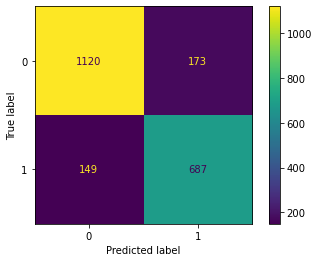

In [41]:
# L2-regularized version
fl_fnn2 = Sequential()
fl_fnn2.add(Dense(units = 32, activation = 'relu', input_shape = (34, ),
    kernel_regularizer = l2(0.005)))
fl_fnn2.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
fl_fnn2.add(Dense(units = 1, activation = 'sigmoid'))

fl_fnn2.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

model_trials_nn('FL', X, y, fl_fnn2, 'fnn2', epochs = 20, batch_size = 256);

ANALYSIS
- As expected, a tiny increase in bias, specificity remains essentially the same as the initial neural network

67/67 [==============================] - 0s 1ms/step
Dataset: FL
Model ID: fnn3
Model Params: {'epochs': 20, 'batch_size': 256}
Training Score: 0.8415
Testing Score: 0.8473 

Accuracy: 0.8473
Specificity: 0.8616
Precision: 0.794
Recall: 0.8254
F1 Score: 0.8094 

Best accuracy rate confusion matrix:


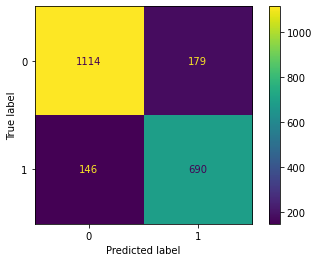

In [42]:
# L2 + Dropouts
fl_fnn3 = Sequential()
fl_fnn3.add(Dense(units = 32, activation = 'relu', input_shape = (34, ), kernel_regularizer = l2(0.005)))
fl_fnn3.add(Dropout(rate = 0.3))
fl_fnn3.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
fl_fnn3.add(Dropout(rate = 0.3))
fl_fnn3.add(Dense(units = 1, activation = 'sigmoid'))

fl_fnn3.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

model_trials_nn('FL', X, y, fl_fnn3, 'fnn3', epochs = 20, batch_size = 256);

ANALYSIS
- Very similar again - no noticeable improvement

67/67 [==============================] - 0s 1ms/step
Dataset: FL
Model ID: fnn4
Model Params: {'epochs': 20, 'batch_size': 256}
Training Score: 0.8463
Testing Score: 0.8506 

Accuracy: 0.8506
Specificity: 0.8732
Precision: 0.8061
Recall: 0.8158
F1 Score: 0.8109 

Best accuracy rate confusion matrix:


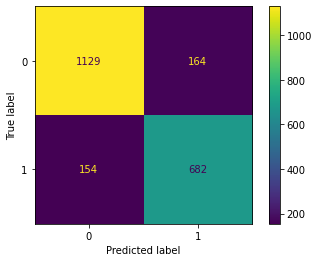

In [43]:
# L2 + early stopping
es = EarlyStopping(patience = 5)
fl_fnn4 = Sequential()
fl_fnn4.add(Dense(units = 32, activation = 'relu', input_shape = (34, ),
    kernel_regularizer = l2(0.005)))
fl_fnn4.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
fl_fnn4.add(Dense(units = 1, activation = 'sigmoid'))

fl_fnn4.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

model_trials_nn('FL', X, y, fl_fnn4, 'fnn4', epochs = 20, batch_size = 256, callbacks = [es]);

ANALYSIS
- Again, no noticeable improvement over initial neural network

CONCLUSIONS
- We will probably be using the tuned GradientBoost as our production model for FL, but we will perform a bit of additional inspection in the final notebook to ensure that this is the best choice.
- Pleased to see that the FNN made a solid showing in this bunch, although the non-neural-net tuned models have a slight edge.

---
**Model 3: Behavioral feature set - Georgia**

In [113]:
# Reading in the cleaned Georgia data file

ga = pd.read_csv('../data/GA/GA_final.csv')
ga.drop(columns='Unnamed: 0', inplace=True)
ga.head()

,gender_male,age_at_release,gang_affiliated,supervision_risk_score_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,...,delinquency_reports,program_attendances,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,recidivism_within_3years
0,1,43-47,0,3.0,at least some college,3,more than 3 years,6,6,1,...,0,6,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0
1,1,33-37,0,6.0,less than hs diploma,1,more than 3 years,7,6,3,...,4,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,1
2,1,48 or older,0,7.0,at least some college,3,1-2 years,6,6,3,...,4,6,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,1
3,1,38-42,0,7.0,less than hs diploma,1,1-2 years,8,6,0,...,0,6,3,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0
4,1,33-37,0,4.0,less than hs diploma,3,1-2 years,4,4,3,...,0,7,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,1


##### Dummifying Categorical Columns

In [114]:
cat_cols = ga.select_dtypes(include='object').columns

ga_dummy = pd.get_dummies(ga, columns=cat_cols)
print(ga_dummy.shape)
ga_dummy.head()

(24426, 43)


,gender_male,gang_affiliated,supervision_risk_score_first,dependents,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,prior_arrest_episodes_property,prior_arrest_episodes_drug,prior_arrest_episodes_ppviolationcharges,...,age_at_release_38-42,age_at_release_43-47,age_at_release_48 or older,education_level_at least some college,education_level_high school diploma,education_level_less than hs diploma,prison_years_1-2 years,prison_years_greater than 2 to 3 years,prison_years_less than 1 year,prison_years_more than 3 years
0,1,0,3.0,3,6,6,1,3,3,4,...,0,1,0,1,0,0,0,0,0,1
1,1,0,6.0,1,7,6,3,0,3,5,...,0,0,0,0,0,1,0,0,0,1
2,1,0,7.0,3,6,6,3,2,2,5,...,0,0,1,1,0,0,1,0,0,0
3,1,0,7.0,1,8,6,0,3,3,3,...,1,0,0,0,0,1,1,0,0,0
4,1,0,4.0,3,4,4,3,2,1,3,...,0,0,0,0,0,1,1,0,0,0


In [46]:
ga_dummy.to_csv('../data/GA/georgia_dummy.csv')

##### Establishing the Baseline

In [115]:
X = ga_dummy.drop(columns='recidivism_within_3years')
y = ga_dummy['recidivism_within_3years']

y.value_counts(normalize=True)

1    0.596496
0    0.403504
Name: recidivism_within_3years, dtype: float64

This baseline is telling us that if we predicted that all observations in this list would recidivate, we could reasonably expect be correct 59.65% of the time.

Depending on the usage of our model, the metrics we want to optimize for are overall accuracy and specificity. 

##### Logistic Regression

Dataset: GA
Model ID: logreg
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.7097
Testing Score: 0.6965 

Accuracy: 0.6965
Specificity: 0.5218
Precision: 0.7157
Recall: 0.8147
F1 Score: 0.762 

Best accuracy rate confusion matrix:


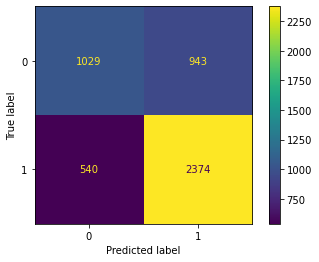

In [116]:
ga_log_reg = LogisticRegression(solver='saga', max_iter = 5000)

model_trials('GA', X, y, ga_log_reg, 'logreg');

ANALYSIS

This model performed better than the baseline by about 10%, but is struggling with correctly predicting the non-recidivist observations (0 class). This may be a result of the data, or could have to do with the distribution of the data (slight lean towards recidivism = True). 

If we see similar misclassifications in some or most of the subsequent models, it may be necessary to rebalance the data via undersampling or resampling with synthetic data points.

##### Multinomial Naive Bayes

Dataset: GA
Model ID: mnb
Model Params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Training Score: 0.6118
Testing Score: 0.6081 

Accuracy: 0.6081
Specificity: 0.4255
Precision: 0.653
Recall: 0.7316
F1 Score: 0.6901 

Best accuracy rate confusion matrix:


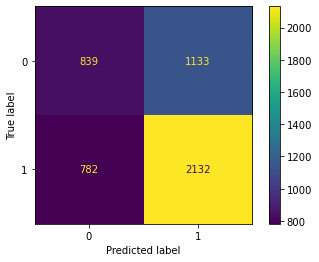

In [117]:
ga_mnb = MultinomialNB()

model_trials('GA', X, y, ga_mnb, 'mnb');

ANALYSIS

This MNB model performed surprisingly poorly and had significantly more false positives and false negatives relative to the Logistic Regression model. 

One possible explanation is that NB classifiers operate on the principle that the presence of one feature does not affect the presence of another. This assumption is not true of this dataset - many features are highly correlated and the presence of 'age_at_release_33-37', for example, would directly result in the absence of a true value in the 'age_at_release_48 or older' column. 

In this case, the model is running on an assumption that is categorically false and would likely run into issues, even in a binary classification model. 

##### KNN Classifier

Dataset: GA
Model ID: knn
Model Params: {'memory': None, 'steps': [('ss', StandardScaler()), ('knn', KNeighborsClassifier())], 'verbose': False, 'ss': StandardScaler(), 'knn': KNeighborsClassifier(), 'ss__copy': True, 'ss__with_mean': True, 'ss__with_std': True, 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Training Score: 0.7695
Testing Score: 0.6502 

Accuracy: 0.6502
Specificity: 0.5345
Precision: 0.6981
Recall: 0.7286
F1 Score: 0.713 

Best accuracy rate confusion matrix:


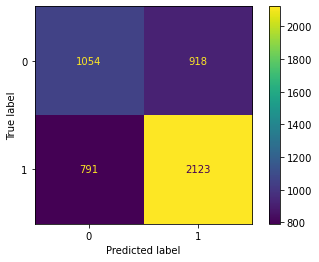

In [118]:
ga_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_trials('GA', X, y, ga_knn, 'knn');

ANALYSIS

Despite the higher scores, the KNN model saw a handful more false negatives compared to the MNB model above. That being said, both models scored not much higher than the baseline and will likely not be used in the model tuning portion. 

Because KNN performs well with a low number of features, it's probable that the 42 features included in the dummy dataframe are creating too much noise for this model to read through. This, in addition to the fact that KNN uses the mode of the closest observations in a classification model (and our data is not evenly balanced) are two feasible explanations of the low scores seen here.

##### Decision Tree Classifier

Dataset: GA
Model ID: dtree
Model Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Training Score: 1.0
Testing Score: 0.6142 

Accuracy: 0.6142
Specificity: 0.5401
Precision: 0.681
Recall: 0.6644
F1 Score: 0.6726 

Best accuracy rate confusion matrix:


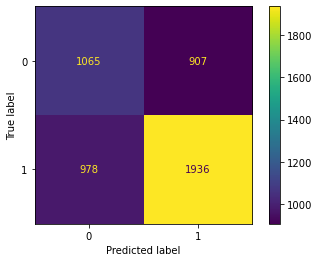

In [119]:
ga_dtree = DecisionTreeClassifier()

model_trials('GA', X, y, ga_dtree, 'dtree');

ANALYSIS

Depending on our evaluation metric, this model did or did not perform well. We're seeing a 0.62 accuracy score, which is not far above the baseline. However, we're also seeing the highest specificity score of the four models tested so far. By definition, this tells us that the Decision Tree model had the lowest number of false positives, and the greatest number of false negatives. 

Additionally, the model is very overfit. While adding max depth or min samples as hyperparameters would likely reduce the variance, we'd still expect a Random Forest or Bagging model to perform better in this context because both are adding randomness to the samples that the Decision Tree model does not.

##### Random Forest Classifier

Dataset: GA
Model ID: rf
Model Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training Score: 1.0
Testing Score: 0.7047 

Accuracy: 0.7047
Specificity: 0.5482
Precision: 0.7261
Recall: 0.8106
F1 Score: 0.766 

Best accuracy rate confusion matrix:


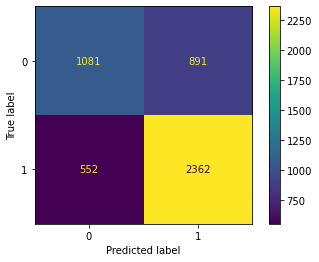

In [120]:
ga_rf = RandomForestClassifier()

model_trials('GA', X, y, ga_rf, 'rf');

ANALYSIS

This model is also very overfit, but significantly decreased the number of false negatives in comparison to the Decision Tree model above. We're seeing the specificity score on par with the prior trials, but the Random Forest model looks to have classified more similarly to the Logistic Regression model than DTree.

The .705 score is our highest accuracy so far, and a strong contender for the upcoming model tuning.

##### Bagging Classifier

Dataset: GA
Model ID: bag
Model Params: {'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training Score: 0.9883
Testing Score: 0.6787 

Accuracy: 0.6787
Specificity: 0.6283
Precision: 0.7391
Recall: 0.7128
F1 Score: 0.7257 

Best accuracy rate confusion matrix:


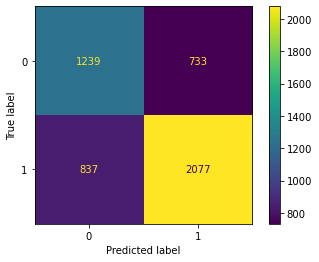

In [121]:
ga_bag = BaggingClassifier()

model_trials('GA', X, y, ga_bag, 'bag');

ANALYSIS

Because Bagging is often used when we need to reduce the variance of a Decision Tree model, this model does meet the objective, in that sense.

However, the model is, again, pretty overfit and scoring higher than the baseline by a slim margin. It does well classifying the true negatives but not as well classifying the true positives, relative to the others. 

Overall, we aren't thrilled with the Bagging accuracy score, but it is the third highest so far and a potential option to carry into model tuning.

##### Ada Boost Classifier

Dataset: GA
Model ID: ada
Model Params: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Training Score: 0.7216
Testing Score: 0.7045 

Accuracy: 0.7045
Specificity: 0.5715
Precision: 0.7326
Recall: 0.7944
F1 Score: 0.7623 

Best accuracy rate confusion matrix:


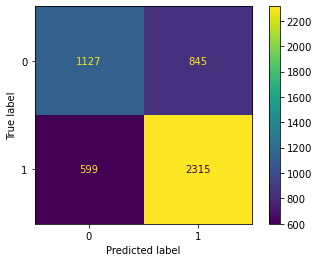

In [122]:
ga_ada = AdaBoostClassifier()

model_trials('GA', X, y, ga_ada, 'ada');

ANALYSIS

In terms of classification, this AdaBoost model classified very closely to the Random Forest model. Where AdaBoost edges ahead is in the variance of the train and test scores. This model got a similar test score to RF, but shrunk the gap between this and the train score almost entirely. 

This is probably a result of the weighing methods within each of the models - while Random Forest allows an equal vote for each tree, AdaBoost gives some trees/stumps more weight in the final classification than others.

As Logistic Regression was another top-performing trial so far, I think that combining this with a boosting model may lead to higher scores.

##### Ada Boost Classifier with Logistic Regression

Dataset: GA
Model ID: ada_lr
Model Params: {'algorithm': 'SAMME.R', 'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Training Score: 0.7084
Testing Score: 0.6981 

Accuracy: 0.6981
Specificity: 0.5248
Precision: 0.7172
Recall: 0.8154
F1 Score: 0.7631 

Best accuracy rate confusion matrix:


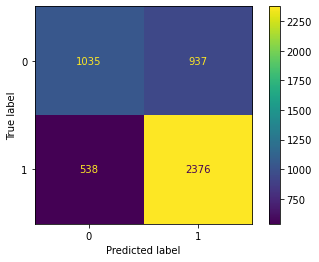

In [123]:
ga_ada_lr = AdaBoostClassifier(base_estimator=LogisticRegression())

model_trials('GA', X, y, ga_ada_lr, 'ada_lr');

ANALYSIS

Replacing the Decision Tree base estimator in the AdaBoost model with Logistic Regression worsened the accuracy by about 0.006. This model more false positive and less false negative predictions. 

Though using Logistic Regression in conjunction with AdaBoost did not improve the scores, the first model did perform relatively well and may be worth exploring further with hyperparameter tuning.

##### Gradient Boosting Classifier

Dataset: GA
Model ID: gboost
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.739
Testing Score: 0.7147 

Accuracy: 0.7147
Specificity: 0.5674
Precision: 0.7356
Recall: 0.8143
F1 Score: 0.773 

Best accuracy rate confusion matrix:


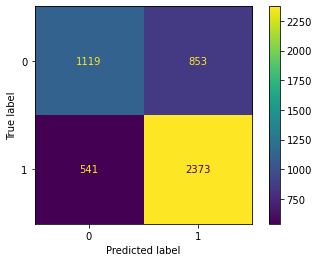

In [124]:
ga_gboost = GradientBoostingClassifier()

model_trials('GA', X, y, ga_gboost, 'gboost');

ANALYSIS

The Gradient Boost had the best test score we've seen so far. Though it did not have the most true negatives or true positives, this model outperformed all others on accuracy because it had low numbers of both misclassification types (whereas most of the other models had an inverse relationship between false positives and false negatives).

This model is also not drastically overfit, meaning it is a great option to move forward into model tuning.

#### Untuned Model Trials Evaluation

Let's check in on our models so far and see which untuned models make the best candidates for further tuning.

In [125]:
ga_untuned_models = ['logreg', 'mnb', 'knn', 'dtree', 'rf', 'bag', 'ada', 'ada_lr', 'gboost']
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'].isin(ga_untuned_models))].sort_values(by='accuracy', ascending = False)

,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,GA,gboost,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373
4,GA,rf,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.000000,0.704666,0.704666,0.548174,0.726099,0.810570,0.766013,1081,891,552,2362
6,GA,ada,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
7,GA,ada_lr,"{'algorithm': 'SAMME.R', 'base_estimator__C': ...",0.708393,0.698117,0.698117,0.524848,0.717175,0.815374,0.763128,1035,937,538,2376
0,GA,logreg,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.709672,0.696480,0.696480,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374
5,GA,bag,"{'base_estimator': None, 'bootstrap': True, 'b...",0.988332,0.678674,0.678674,0.628296,0.739146,0.712766,0.725716,1239,733,837,2077
2,GA,knn,"{'memory': None, 'steps': [('ss', StandardScal...",0.769550,0.650225,0.650225,0.534483,0.698126,0.728552,0.713014,1054,918,791,2123
3,GA,dtree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.000000,0.614204,0.614204,0.540061,0.680971,0.664379,0.672573,1065,907,978,1936
1,GA,mnb,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.611771,0.608064,0.608064,0.425456,0.652986,0.731640,0.690079,839,1133,782,2132


- Of the nine models tested so far, the Gradient Boosting model produced the highest accuracy, precision, and F1 scores.  
- Multinomial Naive Bayes had lowest accuracy and specificity, and appeared to struggle with overpredicting recidivism - this is the only model with greater than 1,000 false positives.
- Gradient Boost had the best overall accuracy, but lost to Bagging and both Ada Boost on specificity.
- Logistic Regression and Gradient Boost had significantly less false negative predictions than most other models, meaning these two were better at not classifying non-recidivism in true recidivism observations.

#### Model Tuning

Here are the previous models, in order of accuracy. I'll be referring to this list to decide which models to add hyperparameters to, and which ones did not score high enough to run again.

##### Gradient Boosting Classifier

In [129]:
print('Previous scores:')
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'] == 'gboost')]

Previous scores:


,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,GA,gboost,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373


In [60]:
ga_gboost2 = GradientBoostingClassifier()

gb_params  = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.7, 0.8, 0.9],
    'max_features': [None, 'sqrt']
}

Dataset: GA
Model ID: gboost2
Model Params: {'learning_rate': 0.7, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
Training Score: 0.7536
Testing Score: 0.7176 

Accuracy: 0.7176
Specificity: 0.5953
Precision: 0.745
Recall: 0.8003
F1 Score: 0.7717 

Best accuracy rate confusion matrix:


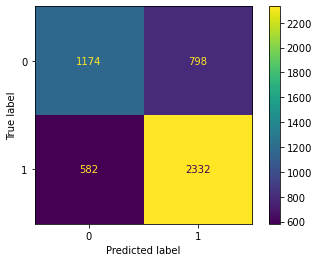

In [61]:
model_trials('GA', X, y, ga_gboost2, 'gboost2', gs_params = gb_params);

ANALYSIS

This model with the tuned hyperparameters scored higher on accuracy than most of the untuned models, and beat the no-param Gradient Boost model. This tuned version decreased the prior GBoost's false positives, but increased the false negatives. Because Gradient Boosting was the previous highest-scoring model, I'm curious to see if any other tuned models can surpass this score, or if the 0.718 is as high as the accuracy will go.

##### Random Forest Classifier

In [130]:
print('Previous scores:')
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'] == 'rf')]

Previous scores:


,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
4,GA,rf,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.704666,0.704666,0.548174,0.726099,0.81057,0.766013,1081,891,552,2362


In [63]:
ga_rf2 = RandomForestClassifier()

rf2_params  = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7],
    'max_features': [None, 'sqrt'],
    'bootstrap' : [True, False]
}

Dataset: GA
Model ID: rf2
Model Params: {'bootstrap': True, 'max_depth': 7, 'max_features': None, 'n_estimators': 150}
Training Score: 0.7421
Testing Score: 0.7034 

Accuracy: 0.7034
Specificity: 0.5527
Precision: 0.7269
Recall: 0.8054
F1 Score: 0.7641 

Best accuracy rate confusion matrix:


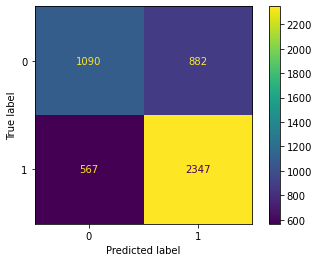

In [64]:
model_trials('GA', X, y, ga_rf2, 'rf2', gs_params = rf2_params);

In [65]:
ga_rf3 = RandomForestClassifier()

rf_3_params  = {
    'n_estimators': [150, 200, 250], 
    'max_depth': [6, 7, 8],
    'bootstrap' : [True],
    'max_samples': [None, 0.5, 0.8]
}

Dataset: GA
Model ID: rf3
Model Params: {'bootstrap': True, 'max_depth': 8, 'max_samples': None, 'n_estimators': 200}
Training Score: 0.7456
Testing Score: 0.7049 

Accuracy: 0.7049
Specificity: 0.4802
Precision: 0.709
Recall: 0.8569
F1 Score: 0.7759 

Best accuracy rate confusion matrix:


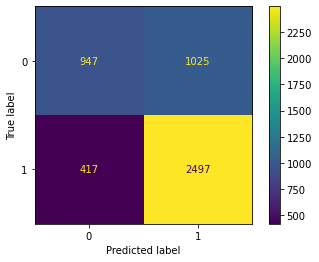

In [67]:
model_trials('GA', X, y, ga_rf3,'rf3', gs_params = rf_3_params);

ANALYSIS

Based on the shift in best params, it looks like the Random Forest model prefers more estimators and a greater max depth, with sample bootstrapping set equal to true. The second tuned model scored a hair above the no-param model on accuracy, as well as drastically reduced the variance and false negative predictions. If we were to choose a Random Forest model to proceed with, I would likely select the second grid-searched model as it scores high and is much less overfit.

##### Ada Boost Classifier

In [131]:
print('Previous scores:')
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'] == 'ada')]

Previous scores:


,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
6,GA,ada,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315


In [69]:
ga_ada2 = AdaBoostClassifier()

ada2_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.7, 0.8, 0.9],
}

Dataset: GA
Model ID: ada
Model Params: {'learning_rate': 0.8, 'n_estimators': 300}
Training Score: 0.7272
Testing Score: 0.7114 

Accuracy: 0.7114
Specificity: 0.574
Precision: 0.7362
Recall: 0.8044
F1 Score: 0.7688 

Best accuracy rate confusion matrix:


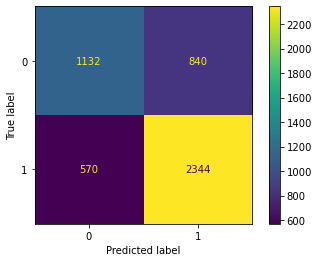

In [70]:
model_trials('GA', X, y, ga_ada2, 'ada', gs_params = ada2_params);

In [71]:
ga_ada3 = AdaBoostClassifier()

ada_params_3 = {
    'n_estimators': [350, 400, 450],
    'learning_rate': [0.6, 0.7, 0.75],
}

Dataset: GA
Model ID: ada3
Model Params: {'learning_rate': 0.6, 'n_estimators': 450}
Training Score: 0.7285
Testing Score: 0.7131 

Accuracy: 0.7131
Specificity: 0.5745
Precision: 0.737
Recall: 0.8068
F1 Score: 0.7703 

Best accuracy rate confusion matrix:


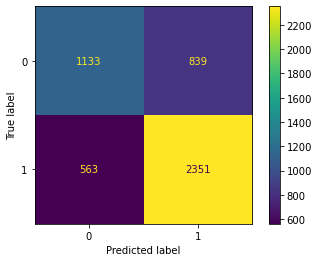

In [73]:
model_trials('GA', X, y, ga_ada3, 'ada3', gs_params = ada_params_3);

ANALYSIS

AdaBoost ranked third-highest in the no-param trials, and now has the third-highest score of all param and no-param models so far. Compared to its no-param counterpart, the second version of the grid searched model predicted 6 fewer false positives and 36 fewer false negatives. Because there is a trade-off between n estimators and learning rate, I inversely shifted the range of the two hyperparameters, and this specific model seemed to prefer the lower learning rate and higher amount of estimators.

##### Logistic Regression

In [132]:
print('Previous scores:')
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'] == 'logreg')]

Previous scores:


,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,GA,logreg,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.709672,0.69648,0.69648,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374


In [75]:
ga_lr2 = LogisticRegression( max_iter=10_000, solver='saga')

lr2_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

Dataset: GA
Model ID: logreg2
Model Params: {'C': 1, 'class_weight': None, 'penalty': 'l1'}
Training Score: 0.71
Testing Score: 0.6965 

Accuracy: 0.6965
Specificity: 0.5213
Precision: 0.7156
Recall: 0.815
F1 Score: 0.7621 

Best accuracy rate confusion matrix:


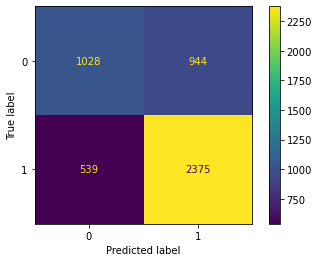

In [76]:
model_trials('GA', X, y, ga_lr2, 'logreg2', gs_params = lr2_params);

ANALYSIS

This tuned model performed exactly the same as the untuned Logistic Regression trial (with one extra false positive and one less false negative), but still did not break the 0.7 accuracy ceiling that other models have. Regarding classifications, LR actually does better than most at predicting true positives but this is likely more related to the distribution of the data than it is the performance of the model, as there are increased false positives as well.

##### Bagging Classifier

In [133]:
print('Previous scores:')
model_trials_df[(model_trials_df['dataset_name'] == 'GA') & (model_trials_df['model_used'] == 'bag')]

Previous scores:


,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
5,GA,bag,"{'base_estimator': None, 'bootstrap': True, 'b...",0.988332,0.678674,0.678674,0.628296,0.739146,0.712766,0.725716,1239,733,837,2077


In [78]:
ga_bag2 = BaggingClassifier(random_state=42, n_jobs= -1)

bag2_params = {
    'max_samples': [0.5, 0.8, 0.9],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

Dataset: GA
Model ID: bag2
Model Params: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}
Training Score: 0.9713
Testing Score: 0.6793 

Accuracy: 0.6793
Specificity: 0.6329
Precision: 0.741
Recall: 0.7107
F1 Score: 0.7255 

Best accuracy rate confusion matrix:


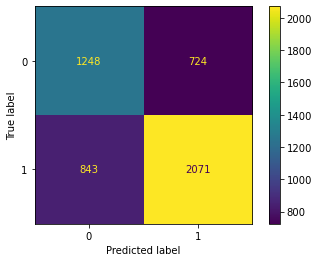

In [80]:
model_trials('GA', X, y, ga_bag2, 'bag2', gs_params = bag2_params);

In [81]:
ga_bag_3 = BaggingClassifier(random_state=42, n_jobs= -1)

bag_3_params = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.6],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

Dataset: GA
Model ID: bag3
Model Params: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.5, 'n_estimators': 300}
Training Score: 0.9999
Testing Score: 0.7049 

Accuracy: 0.7049
Specificity: 0.5198
Precision: 0.7187
Recall: 0.8301
F1 Score: 0.7704 

Best accuracy rate confusion matrix:


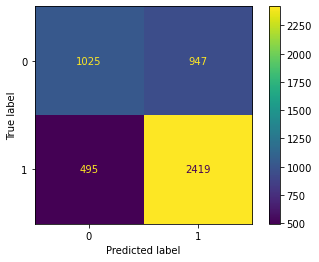

In [82]:
model_trials('GA', X, y, ga_bag_3, 'bag3', gs_params = bag_3_params);

ANALYSIS

Through grid searching, we were able to increase the no-param accuracy scores and beat the 0.7 threshold. However, all three Bagging models we've tested have been particularly overfit, and still not scoring as well on the test set as other more biased models. In all, this is not a model we'd recommend moving forward with in any real-world scenario.

##### Additional Investigation: GA Dataset Feature Importance

In [85]:
X = ga_dummy.drop(columns='recidivism_within_3years')
y = ga_dummy['recidivism_within_3years']

log_reg = LogisticRegression(solver='saga', max_iter = 5000)

log_reg.fit(X, y)

LogisticRegression(max_iter=5000, solver='saga')

In [86]:
fi = log_reg.coef_[0]
fi_zipped = list(zip(X.columns, fi))

feats = pd.DataFrame(columns=['feature', 'coef'])

for i in list(range(len(fi_zipped))):
    feats.loc[i] = [fi_zipped[i][0], np.exp(fi_zipped[i][1])]

feats = feats.sort_values(by='coef', ascending=False)
feats.head(10)

,feature,coef
1,gang_affiliated,2.011800
28,age_at_release_18-22,1.485400
29,age_at_release_23-27,1.348292
0,gender_male,1.345022
12,condition_mh_sa,1.287948
23,drugtests_thc_positive,1.259186
16,violations_instruction,1.252103
15,violations_electronicmonitoring,1.182378
21,residence_changes,1.148553
9,prior_arrest_episodes_ppviolationcharges,1.105202


In [87]:
feats.tail(10)

,feature,coef
19,delinquency_reports,0.893716
31,age_at_release_33-37,0.892412
41,prison_years_more than 3 years,0.841966
37,education_level_less than hs diploma,0.841486
32,age_at_release_38-42,0.825286
35,education_level_at least some college,0.784384
39,prison_years_greater than 2 to 3 years,0.771787
33,age_at_release_43-47,0.742762
34,age_at_release_48 or older,0.564147
27,percent_days_employed,0.294066


ANALYSIS 
- Based on the above, we can see that those who are gang affiliated are twice as likely to recidivate than those who are not.
- Holding all else equal, individuals in the two youngest age groups (18-22 and 23-27) are 35% to 49% more likely to recidivate than those who are not in either age range.
- Men are 35% more likely to recidivate than women.
- Regarding percent of days employed during parole, 21% of observations worked 100% of the days and 31% did not work at all. Those who did not work at all were 71% more likely to recidivate than those who worked all days.
- Individuals who had at least some college experience were 20% less likely to recidivate than those who had no college experience.

In [88]:
# save our important features out for later use if needed
feats.to_csv('../data/GA/important_feats.csv')

---

**FINAL NOTES**

In [ ]:
# Export all statistics for later analysis
model_trials_df.to_csv('../data/model_stats.csv', index = False)

In [ ]:
# pickle favorite models for each dataset
# NOTE these final choices were actually made in the Results notebook
# saving them here while we have them in memory

# NY - FNN
ny_nn.save('../models/ny_best_model_nn.ksm') # using keras' save functionality rather than pickling for neural nets

# FL - GradientBoost
with open('../models/fl_best_model_grad.pkl', 'wb') as f:
    pickle.dump(fl_grad, f)

# GA - tuned GradientBoost
with open('../models/ga_best_model_gboost2.pkl', 'wb') as f:
    pickle.dump(ga_gboost2, f)

- The model statistics are exported [here](../data/model_stats.csv).
- The pickled models can be found in the **models** subdirectory.
- The next formal notebook in the series is [Results and Recommendations](./04_results.ipynb).
- To see some experimental modeling, including NLP and feature-importance focused models, see [Experiments](./03a_experiments.ipynb).